# Joint Cross-Attnetion Fusion Net (JCAF-Net)

### 1. Inputs gaze and mouse:
- X/Y coordinates
- Speed and direction (velocity)
- Joint features: Euclidean distance, direcational angle between gaze and mouse

### 2. Dual-Pathway design:
- Cross-Attention Path: Learns interations between gaze and mouse using attention scores
- Joint Feature Path: Processes handcrafted joint features (e.g. distance, angle) with CNNs
- WARNING: VERY FEW DATA (AND BAD QUALITY) FOR THE MOUSE

### 3. Feature Extractor:
- ResNet-34 (2D CNNs) as backbone for unimodal (gaze and mouse) and joint inputs

### 4. Cross-Attention Module:
- Applied mid-way trough ResNet (between resudial blocks 2 and 3)
- Attends to gaze features using mouse as key/value and vice versa

### 5. Fusion and Classification:
- Attended features + joint CNN features are concatenated
- FCN (with re-weighting) produces final class logits.


In [ ]:
# TODO: 
# - ADD A BOOLEAN MASK IDENTIFYING MISSING VALUES FOR MOUSE AND GAZE ?

In [2]:
import pandas as pd
import numpy as np
import os

from pathlib import Path

os.chdir('/cluster/home/kruu/git/eye_tracking/')
# os.chdir('/home/kruu/git_folder/eye_tracking/')
from utils.data_processing import EyeTrackingProcessor

import json
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
from models.jcafnet import JCAFNet
from utils.train import train_classifier, split_by_participant, export_to_onnx
from utils.dataset import GazeMouseDatasetJCAFNet

from utils.data_processing import EyeTrackingProcessor, GazeMetricsProcessor, MouseMetricsProcessor

In [3]:
# data_path = "/store/kruu/eye_tracking"
data_path = "/cluster/home/kruu/store/eye_tracking"
files_list = os.listdir(data_path)
files_list = [os.path.join(data_path, file) for file in files_list]

tasks = ['Task 1', 'Task 2', 'Task 3', 'Task 4', 'Task 5', 'Task 6']
features = ['Recording timestamp', 'Gaze point X', 'Gaze point Y', 'Mouse position X', 'Mouse position Y', 'Event', 'Participant name']
interpolate_col = ['Recording timestamp', 'Gaze point X', 'Gaze point Y', 'Mouse position X', 'Mouse position Y', 'Blink']

processor = EyeTrackingProcessor()
all_data = processor.load_data(files_list)
dataset = processor.get_features(all_data, tasks, features)
dataset, blinks = processor.detect_blinks(dataset)

# Fixed Time step resampling
dataset_time_resampled = processor.resample_tasks_fixed_time(dataset, interpolate_col, timestep = 0.01)
dataset_time_resampled.Blink = (dataset_time_resampled.Blink > 0.5) #Transform interpolated data
dataset_time_resampled["id"] = dataset_time_resampled["Participant name"].astype(str) + "_" + dataset_time_resampled["Task_id"].astype(str) + "_" + dataset_time_resampled["Task_execution"].astype(str)

dataset_time_resampled["Mouse position X"] = dataset_time_resampled["Mouse position X"].ffill().bfill()
dataset_time_resampled["Mouse position Y"] = dataset_time_resampled["Mouse position Y"].ffill().bfill()
dataset_time_resampled["Gaze point X"] = dataset_time_resampled["Gaze point X"].ffill().bfill()
dataset_time_resampled["Gaze point Y"] = dataset_time_resampled["Gaze point Y"].ffill().bfill()

/cluster/home/kruu/git/eye_tracking/utils/data_processing.py:14: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep='\t')
/cluster/home/kruu/git/eye_tracking/utils/data_processing.py:14: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep='\t')
/cluster/home/kruu/git/eye_tracking/utils/data_processing.py:14: DtypeWarning: Columns (75,76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep='\t')
/cluster/home/kruu/git/eye_tracking/utils/data_processing.py:14: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep='\t')


In [4]:
def compute_joint_features(df):
    gx, gy = df["Gaze point X"].fillna(0), df["Gaze point Y"].fillna(0)
    mx, my = df["Mouse position X"].fillna(0), df["Mouse position Y"].fillna(0)

    distance = np.sqrt((gx - mx)**2 + (gy - my)**2)
    angle = np.arctan2(gy - my, gx - mx)  # radians
    return distance, angle

#Enrich dataframe with metrics for JCAFNet
def enrich_with_gaze_mouse_metrics(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    df["Gaze Velocity"] = np.nan
    df["Gaze Acceleration"] = np.nan
    df["Mouse Velocity"] = np.nan
    df["Mouse Acceleration"] = np.nan
    df["Gaze-Mouse Distance"] = np.nan
    df["Angle Between Gaze and Mouse"] = np.nan

    task_group = df.groupby("id")

    for id, group in tqdm(task_group, desc="Enriching metrics"):
        mask = df["id"] == id

        # Gaze metrics
        gaze_proc = GazeMetricsProcessor(group)
        gaze_vel, gaze_acc = gaze_proc.compute_velocity_acceleration()
        df.loc[mask, "Gaze Velocity"] = gaze_vel.fillna(0).values
        df.loc[mask, "Gaze Acceleration"] = gaze_acc.fillna(0).values

        # Mouse metrics
        mouse_proc = MouseMetricsProcessor(group)
        mouse_vel, mouse_acc = mouse_proc.compute_velocity_acceleration()
        df.loc[mask, "Mouse Velocity"] = mouse_vel.fillna(0).values
        df.loc[mask, "Mouse Acceleration"] = mouse_acc.fillna(0).values

        # Joint features
        dist, angle = compute_joint_features(group)
        df.loc[mask, "Gaze-Mouse Distance"] = dist.fillna(0).values
        df.loc[mask, "Angle Between Gaze and Mouse"] = angle.fillna(0).values

    return df

In [5]:
dataset_enriched = enrich_with_gaze_mouse_metrics(dataset_time_resampled)

Enriching metrics: 100%|██████████| 684/684 [01:02<00:00, 11.00it/s]


In [6]:
features = {
    "gaze": ["Gaze point X", "Gaze point Y", "Gaze Velocity", "Gaze Acceleration"],
    "mouse": ["Mouse position X", "Mouse position Y", "Mouse Velocity", "Mouse Acceleration"],
    "joint": ["Gaze-Mouse Distance", "Angle Between Gaze and Mouse"]
}

gaze_dim = len(features["gaze"])
mouse_dim = len(features["mouse"])
joint_dim = len(features["joint"])
num_classes = 6
batch_size = 32
lr = 0.001
num_epochs = 100
data_augment = True

train_df, val_df, test_df = split_by_participant(dataset_enriched, val_split=0.2, test_split=0.1)
model = JCAFNet(num_classes, gaze_dim, mouse_dim, joint_dim, lr)

model_trained, mean, std, best_ckpt_path = train_classifier(model,
                                    train_df,
                                    val_df,
                                    features,
                                    num_epochs=num_epochs,
                                    data_augment=data_augment,
                                    use_wandb=True)

export_dir = Path(best_ckpt_path).parent.parent
metadata = {
    "features": features,
    "mean": {k: float(v) for k, v in mean.to_dict().items()},
    "std": {k: float(v) for k, v in std.to_dict().items()},
    "train_ids": train_df["id"].unique().tolist(),
    "val_ids": val_df["id"].unique().tolist(),
    "test_ids": test_df["id"].unique().tolist(),
    "num_classes": num_classes,
    "batch_size": batch_size,
    "data_augmentation": data_augment,
}

# Save to JSON
metadata_path = os.path.join(export_dir,"model_metadata.json")
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=4)

print(f"✅ Metadata saved to {metadata_path}")

/raid/persistent_scratch/kruu/venvs/aware/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/raid/persistent_scratch/kruu/venvs/aware/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/raid/persistent_scratch/kruu/venvs/aware/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /raid/persistent_scratch/kruu/venvs/aware/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/raid/persistent_scratch/kruu/venvs/aware/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:378: Found unsupported keys in the optimizer configuration: {'gradient_clip_val'}

  | Name            | Type                | Params | Mode 
----------------------------------------------------------------
0 | gaze_backbone   | ResNet              | 21.3 M | train
1 | mouse_backbone  | ResNet              | 21.3 M | train
2 | joint_backbone  | JointFeatureCNN     | 25.8 K | train
3 | cross_attention | CrossAttentionBlock | 787 K  | train
4 | fc_fusion       | Sequential          | 593 K  | train
5 | criterion       | FocalLoss           | 0      | train
6 | train_accuracy  | MulticlassAccuracy  | 0      | train
7 | val_accuracy    | MulticlassAccuracy  | 0      | train
----------------------------------------------------------------
44.0 M    Trainable params
0         Non-trainable params
44.0 M    Total params
175.931   Total estimated 

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/raid/persistent_scratch/kruu/venvs/aware/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


/raid/persistent_scratch/kruu/venvs/aware/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 99: 100%|██████████| 15/15 [00:03<00:00,  4.27it/s, v_num=lzp2, train_loss_step=0.145, val_loss=0.737, val_acc=0.646, train_loss_epoch=0.121, train_acc_epoch=0.979] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 15/15 [00:08<00:00,  1.68it/s, v_num=lzp2, train_loss_step=0.145, val_loss=0.737, val_acc=0.646, train_loss_epoch=0.121, train_acc_epoch=0.979]
✅ Metadata saved to GazeMouse_Classification/45w6lzp2/model_metadata.json


****
# Evaluate Model
****

In [10]:
from utils.train import evaluate_pytorch_model

ckpt_path ="/cluster/home/kruu/git/eye_tracking/GazeMouse_Classification/45w6lzp2/checkpoints/epoch41-val_acc0.75.ckpt"
metadata_path = '/cluster/home/kruu/git/eye_tracking/GazeMouse_Classification/45w6lzp2/model_metadata.json'
with open(metadata_path, "r") as f:
    metadata = json.load(f)

model_ckpt = JCAFNet.load_from_checkpoint(ckpt_path)
model_ckpt.eval()

res_train_pytorch = evaluate_pytorch_model(model_ckpt,
                                           dataset_enriched[dataset_enriched["id"].isin(metadata["test_ids"])],
                                           metadata["features"],
                                           metadata["num_classes"],
                                           metadata["mean"], 
                                           metadata["std"])

/raid/persistent_scratch/kruu/venvs/aware/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/raid/persistent_scratch/kruu/venvs/aware/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/cluster/home/kruu/git/eye_tracking/utils/dataset.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[self.features] = (dataset[self.features] - self.mean) / self.std
/cluster

🧠 PyTorch Evaluation: Loss = 1.1882, Accuracy = 0.7639


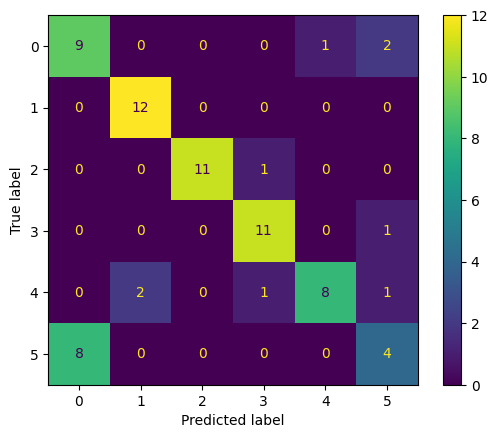

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(res_train_pytorch["labels"], res_train_pytorch["predictions"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

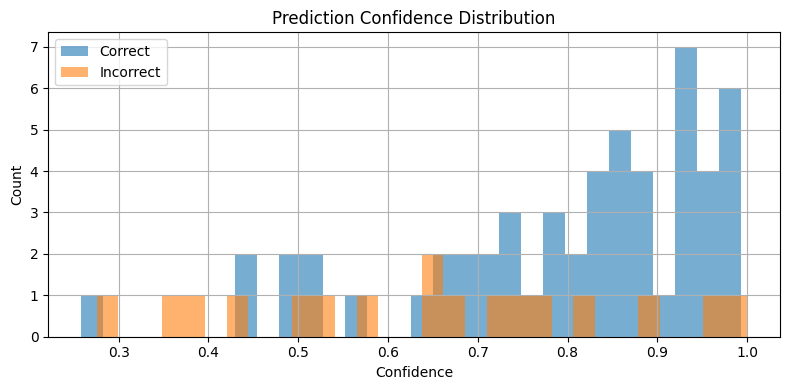

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(
    [c for c, correct in zip(res_train_pytorch["probs"], res_train_pytorch["correct_flags"]) if correct],
    bins=30, alpha=0.6, label="Correct"
)
plt.hist(
    [c for c, correct in zip(res_train_pytorch["probs"], res_train_pytorch["correct_flags"]) if not correct],
    bins=30, alpha=0.6, label="Incorrect"
)
plt.title("Prediction Confidence Distribution")
plt.xlabel("Confidence")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()